# 9.2 EM algorithm on the Old Faithful dataset

Reproducing Figure 9.8.
Old Faithful data from [here](http://research.microsoft.com/en-us/um/people/cmbishop/PRML/webdatasets/faithful.txt).

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

## Load the data and standarize

In [2]:
data = np.loadtxt('../data/old_faithful/faithful.txt', dtype=str, delimiter=' ')

In [3]:
data = data.astype(np.float64)

In [4]:
data.shape

(272, 2)

In [5]:
N = data.shape[0]  # number of data points
D = data.shape[1]  # dimension of data
K = 2  # number of clusters

In [6]:
MEAN = np.mean(data, axis=0, keepdims=True)
SD = np.std(data, axis=0, keepdims=True) 

In [7]:
X = (data - MEAN) / SD  # standarized

In [8]:
np.mean(X, axis=0)  # confirm zero mean

array([4.48579082e-16, 4.27048103e-16])

In [9]:
np.std(X, axis=0)  # confirm unit variance

array([1., 1.])

In [10]:
# initial values (deliverately chosen to be poor values)
pis = np.array([0.5, 0.5])
mus = np.array([[1.4, -1], [-1.4, 1]])

scale = 0.5
covs = np.array([scale * np.eye(2), scale * np.eye(2)])

In [11]:
def plot_data_with_contour(X, mus, covs, gamma=None, L=None):
    """
    Args:
        X (np.array): data (N, D)
        mus (np.array): means (K, D)
        covs (np.array): covariance matrices (K, D, D)
        gamma (np.array): responsibilities (N, K)
        L (int): number of M-steps performed

    Returns:
        None
    """
    colors = ('red', 'blue')

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    
    # scatter plot
    if gamma is None:  # initial state where responsibilities are not calculated yet
        ax.scatter(X[:, 0], X[:, 1], c='green', s=12)
    else:
        gamma_color = np.vstack([gamma[:, 0], np.zeros(X.shape[0]), gamma[:, 1]]).T  #  only using R and B, so set G to zero
        ax.scatter(X[:, 0], X[:, 1], c=gamma_color, s=12)
    
    # contour plot    
    grid = np.linspace(-2.5, 2.5, 100)
    x, y = np.meshgrid(grid, grid)
    pos = np.dstack((x, y))
    
    for k in range(K):
        p = multivariate_normal(mean=mus[k], cov=covs[k])
        level = p.pdf(mus[k]) * np.exp(-1./2)  # 1 S.D. contour (cf. Figure 2.7)
        contours = ax.contour(x, y, p.pdf(pos), levels=[level], colors='white')  # thick white line in the back to make it easier to see
        for line in contours.collections:
            line.set_linewidth(6)
        contours = ax.contour(x, y, p.pdf(pos), levels=[level], colors=colors[k])
        for line in contours.collections:
            line.set_linewidth(2)
    
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([-2, 0, 2])
    ax.tick_params(labelsize=10, direction='in', which='both', right=True, top=True)
    if L is not None:
        ax.text(-2, 1.6, f'L = {L + 1}')  # number of iterations
    plt.show()

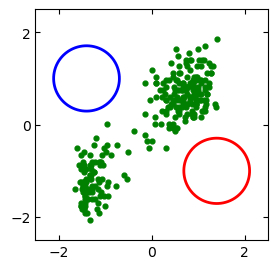

In [12]:
plot_data_with_contour(X, mus, covs)

In [13]:
def E_step(X, pis, mus, covs):
    """ calculate responsibilities given the old parameter
    Args:
        X (np.array): data (N, D)
        pis (np.array): mixing coefficints (K, )
        mus (np.array): means (K, D)
        covs (np.array): covariance matrices (K, D, D)

    Returns:
        gamma (np.array): responsibilities (N, K)
    """
    gamma = np.zeros((N, K))
    for k in range(K):
        p = multivariate_normal(mean=mus[k], cov=covs[k])
        gamma[:, k] = pis[k] * p.pdf(X)
    gamma = gamma / gamma.sum(axis=1, keepdims=1)  # normalize such that each row sums to 1

    return gamma

In [14]:
def M_step(X, gamma):
    """Find the parameters that maximizes the log-likelihood

    Note: code optimized for readability, not for efficiency.

    Args:
        X (np.array): data (N, D)
        gamma (np.array): responsibilities (N, K)

    Returns:
        pis (np.array): updated mixing coefficients (K, )
        mus (np.array): updated means (K, D)
        covs (np.array): updated covariance matrices (K, D, D)
    """
    N = X.shape[0]  # number of data points
    D = X.shape[1]  # number of dimensions
    K = gamma.shape[1]  # number of mixtures

    # initialize parameters
    pis = np.zeros((K, ))
    mus = np.zeros((K, D))
    covs = np.zeros((K, D, D))

    for k in range(K):
        N_k = gamma[:, k].sum()  # (9.18)
        pis[k] = N_k / N  # (9.22)

        # total_mu = 0
        # for n in range(N):
        #     total_mu += gamma[n, k] *  X[n]
        # total_mu
        mus[k] = (1 / N_k) * (gamma[:, [k]] * X).sum(axis=0) # (9.17)

        # total_cov = 0
        # for n in range(N):
        #     res = np.expand_dims(X[n] - mus[k], axis=-1)  # (D, 1)
        #     total_cov += gamma[n, k] * res @ res.T  # (D, D)
        # covs[k] = (1 / N_k) * total_cov  # (9.19)

        # a lower readability but no looping over N (9.19)
        diff = np.einsum('ijk,ikl->ijl', np.expand_dims(X-mus[k], 2), np.expand_dims(X-mus[k], 1))  # (N, D, D)
        weighted_diff = np.expand_dims(gamma[:, k], (1, 2)) * diff  # (N, 1, 1) * (N, D, D)
        covs[k] = (1 / N_k) * weighted_diff.sum(axis=0)  # (D, D)

    return pis, mus, covs

In [15]:
def log_likelihood(X, pis, mus, covs):
    """Evaluate the log_likelihood given in (9.28)

    Args:
        X (np.array): data (X, D)
        pis (np.array): mixing coefficients (K, )
        mus (np.array): means (K, D)
        covs (np.array): covs (K, D, D)

    Returns:
        log_likelihood (float):

    """
    K = mus.shape[0]  # number of clusters
    N = X.shape[0]  # number of data points

    sum_n = 0
    for n in range(N):
        sum_k = 0
        for k in range(K):
            p = multivariate_normal(mean=mus[k], cov=covs[k])
            sum_k += pis[k] * p.pdf(X[n])
        sum_n += np.log(sum_k)
    log_likelihood = sum_n

    return log_likelihood

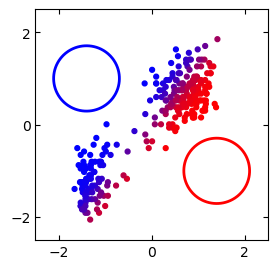

In [16]:
# visualize the first E-step (calculation of responsibilities)
gamma = E_step(X, pis, mus, covs)
plot_data_with_contour(X, mus, covs, gamma)

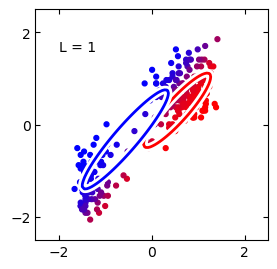

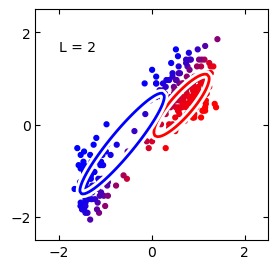

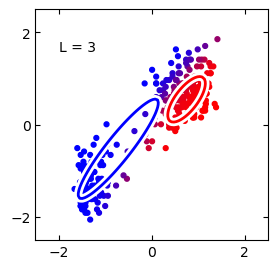

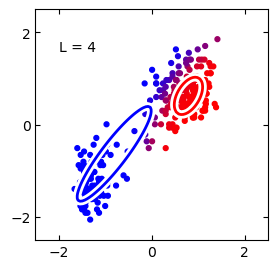

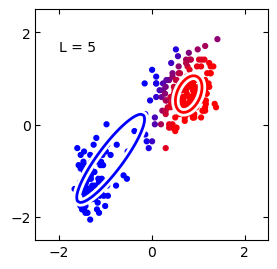

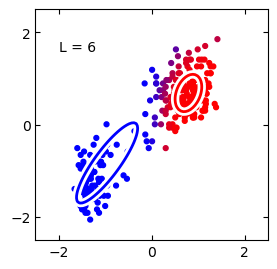

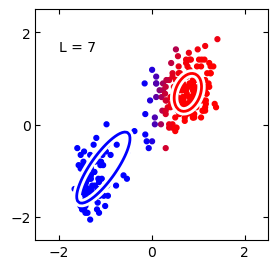

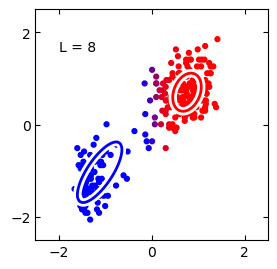

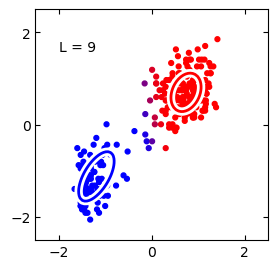

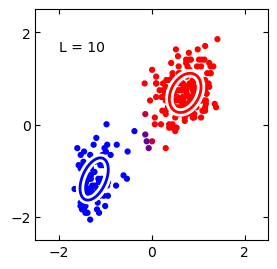

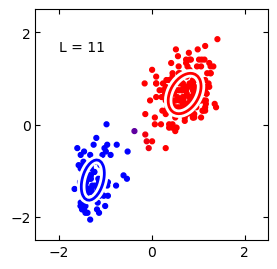

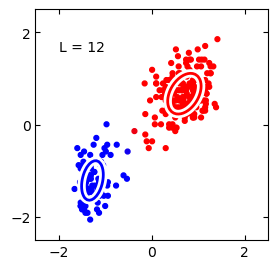

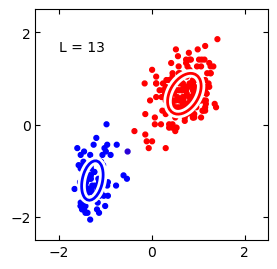

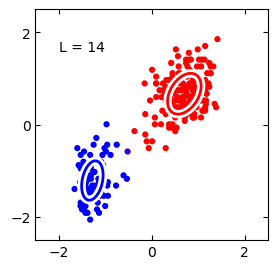

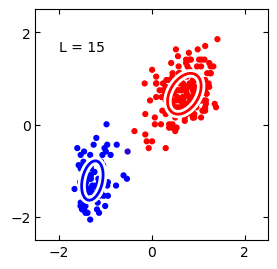

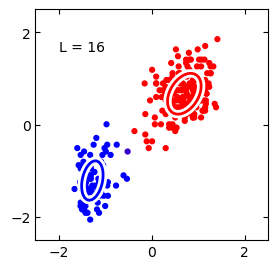

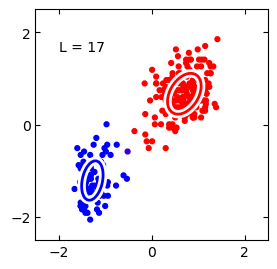

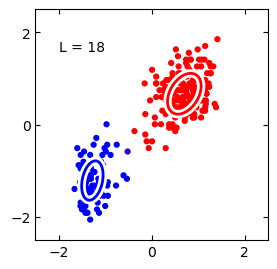

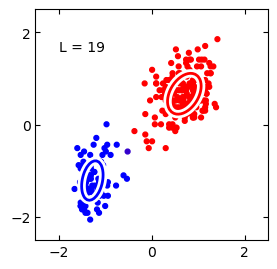

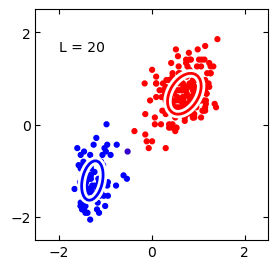

In [17]:
n_iter = 20

# re-initial values
pis = np.array([0.5, 0.5])
mus = np.array([[1.4, -1], [-1.4, 1]])

scale = 0.5
covs = np.array([scale * np.eye(2), scale * np.eye(2)])

LL = []
LL.append(log_likelihood(X, pis, mus, covs))
for L in range(n_iter):
    gamma = E_step(X, pis, mus, covs)
    pis, mus, covs = M_step(X, gamma)
    LL.append(log_likelihood(X, pis, mus, covs))
    plot_data_with_contour(X, mus, covs, gamma, L)

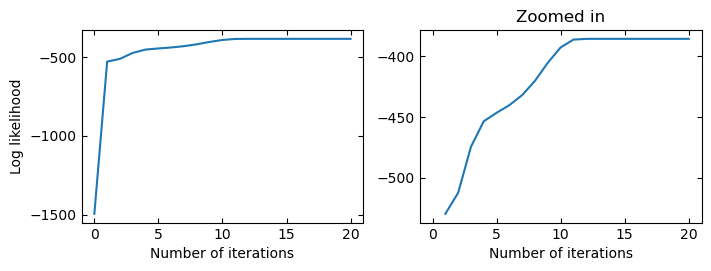

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8, 2.5), sharex=True)
ax[0].plot(range(n_iter + 1), LL, '-')
ax[0].set_xticks(np.arange(0, n_iter + 1, 5))
ax[0].set_yticks([-1500, -1000, -500])
ax[0].tick_params(labelsize=10, direction='in', which='both', right=True, top=True)
ax[0].set_xlabel('Number of iterations')
ax[0].set_ylabel('Log likelihood')

ax[1].plot(range(1, n_iter + 1), LL[1:], '-')
ax[1].set_xticks(np.arange(0, n_iter + 1, 5))
ax[1].tick_params(labelsize=10, direction='in', which='both', right=True, top=True)
ax[1].set_yticks([-500, -450, -400])
ax[1].set_xlabel('Number of iterations')
ax[1].set_title('Zoomed in')
plt.show()